# 라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import Cityscapes

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

# CUDA 설정

In [ ]:
torch.manual_seed(777)

In [ ]:
torch.cuda.manual_seed_all(777)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# 데이터 전처리

In [ ]:
mapping_9 = { 
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 8,
        5: 8,
        6: 8,
        7: 1,
        8: 1,
        9: 1,
        10: 1,
        11: 4,
        12: 4,
        13: 4,
        14: 4,
        15: 4,
        16: 4,
        17: 5,
        18: 5,
        19: 5,
        20: 5,
        21: 6,
        22: 6,
        23: 7,
        24: 2,
        25: 2,
        26: 3,
        27: 3,
        28: 3,
        29: 3,
        30: 3,
        31: 3,
        32: 3,
        33: 3,
        -1: 0
    }

In [ ]:
def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_9:
        label_mask[mask == k] = mapping_9[k]
    return torch.LongTensor(label_mask)

# Custom Dataset

In [ ]:
class Customdataset(nn.Module):
    def __init__(self, mode='train'):
        self.train_trans = transforms.Compose([
            transforms.Resize((128, 256)),
            transforms.ToTensor(),
        ])
        
        self.target_trans = transforms.Compose([
            transforms.Resize((128, 256)),
        ])
        
        self.mode = mode
        
        
        self.train_dataset = Cityscapes(root='/data/Segdata2', split=mode, 
                     mode='fine', target_type='semantic', transform=self.train_trans,
                                       target_transform=self.target_trans)

    def __len__(self):
        return len(self.train_dataset)
    
    def __getitem__(self, idx):
        data, target = self.train_dataset[idx]
        if self.mode=='train':
            data = np.array(data)
            data = torch.Tensor(data)
            target = encode_labels(np.array(target))
        else:
            target = encode_labels(np.array(target))
            
        return data, target

In [ ]:
train_dataset = Customdataset()
val_dataset = Customdataset('val')
test_dataset = Customdataset('test')

In [ ]:
batch_size = 4
train_load = DataLoader(train_dataset, batch_size, num_workers=8, shuffle=True)
val_load = DataLoader(val_dataset, batch_size, num_workers=8, shuffle=True)
test_load = DataLoader(test_dataset, batch_size, num_workers=8, shuffle=True)

# Model

## unet with resnet backbone(convtranspose2d)

In [ ]:
import torch.nn as nn
import torchvision.models


def upconv(in_channels, mid_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, 3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(),
        nn.Dropout(0.8),
        nn.Conv2d(mid_channels, mid_channels, 3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(),
        nn.Dropout(0.8),
        nn.ConvTranspose2d(mid_channels, out_channels, 3, 2, 1, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    return block

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True),
)



class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up3 = upconv(256 + 512, 512 ,512)
        self.conv_up2 = upconv(128 + 512, 256 ,256)
        self.conv_up1 = upconv(64 + 256, 256 ,256)
        self.conv_up0 = upconv(64 + 256, 128 ,128)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        
        x = self.upsample(layer4)
        
        
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

## Unet with vgg backbone

In [ ]:
import torch
import torchvision.models as models

def decoder(in_channels, mid_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, 3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(),
        nn.Conv2d(mid_channels, mid_channels, 3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(),
        nn.ConvTranspose2d(mid_channels, out_channels, 3, 2, 1, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    return block

class vgg_unet(nn.Module):
    def __init__(self, num_class) -> None:
        super(vgg_unet, self).__init__()

        self.pool = nn.MaxPool2d(2, 2)

        self.base = models.vgg11(pretrained=True).features

        self.conv1 = self.base[0:2]
        self.conv2 = self.base[3:5]
        self.conv3 = self.base[6:10]
        self.conv4 = self.base[11:15]
        self.conv5 = self.base[16:20]

        self.mid = decoder(512, 512, 256) # 한번 업샘플링 후에 concat해서 업샘플링 진행

        self.dec1 = decoder(256+512, 512, 256)
        self.dec2 = decoder(256+512, 512, 128)
        self.dec3 = decoder(128+256, 256, 128)
        self.dec4 = decoder(128+128, 128, 64)
        self.dec5 = nn.Sequential(
            nn.Conv2d(64+64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.out = nn.Conv2d(64, num_class, 1)
        
        self.drop = nn.Dropout(0.2)
        

  

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.drop(conv1)
        pool1 = self.pool(conv1)

        conv2 = self.conv2(pool1)
        conv2 = self.drop(conv2)
        pool2 = self.pool(conv2)

        conv3 = self.conv3(pool2)
        conv3 = self.drop(conv3)
        pool3 = self.pool(conv3)

        conv4 = self.conv4(pool3)
        conv4 = self.drop(conv4)
        pool4 = self.pool(conv4)

        conv5 = self.conv5(pool4)
        #conv5 = self.drop(conv5)
        pool5 = self.pool(conv5)

        mid = self.mid(pool5)

        dec1 = self.dec1(torch.cat([mid, conv5], 1))
        dec2 = self.dec2(torch.cat([dec1, conv4], 1))
        dec3 = self.dec3(torch.cat([dec2, conv3], 1))
        dec4 = self.dec4(torch.cat([dec3, conv2], 1))
        dec5 = self.dec5(torch.cat([dec4, conv1], 1))

        return self.out(dec5)

# 학습

In [ ]:
import torchmetrics

criterion = nn.CrossEntropyLoss().to(device)
model = vgg_unet(9)
model = model.to(device)
metrics = torchmetrics.IoU(num_classes=9).to(device)


opt = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8)

## 평가 함수

In [ ]:
def evaluate(model, val_load):
    model.eval()
    
    val_loss = 0
    
    iou = 0
    
    with torch.no_grad():
        for data, label in val_load:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            
            loss = criterion(output, label)
            val_loss = loss.item()
            
            pred = output
            
            pred = pred.argmax(dim=1)
            
            iou += metrics(pred, label).item()
            
        val_loss /= len(val_load)
        iou /= len(val_load)
    
    return val_loss, iou

## 학습

In [ ]:
# label값을 tensor로 바꾼후 model을 예측을 max로 바꾼후 loss 계산
from tqdm import tqdm

train_loss = []

val_loss = []

train_acc = []

val_acc = []


for epoch in range(300):
    model.train()

    cost = 0
    
    epoch_loss = 0
    
    acc = 0
    
    epoch_acc = 0

    for batch, train in tqdm(enumerate(train_load), total=len(train_load)):
        data, label = train
        
        data = data.to(device)
        
        label = label.to(device)
        
        opt.zero_grad()
        
        out = model(data)
        
        loss = criterion(out, label)
        
        pred = out
        
        pred = pred.argmax(dim=1)
        
        cost += loss.item()
        
        acc += metrics(pred, label).item()

        
        loss.backward()
        opt.step()
        

        
    epoch_loss = cost / len(train_load)
    
    epoch_acc = acc / len(train_load)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    loss_val, accuracy_val = evaluate(model, val_load)
    val_loss.append(loss_val)
    val_acc.append(accuracy_val)
    
    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t iou : {epoch_acc:.6f}\t val_loss : {loss_val:.6f}\t val_IOU : {accuracy_val:.6f}')
    

    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.25it/s]


epoch : 1	 Loss : 0.624092	 iou : 0.479029	 val_loss : 0.003981	 val_IOU : 0.496388


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.23it/s]


epoch : 2	 Loss : 0.468810	 iou : 0.561135	 val_loss : 0.003447	 val_IOU : 0.547589


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 3	 Loss : 0.424768	 iou : 0.592325	 val_loss : 0.004579	 val_IOU : 0.568603


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 4	 Loss : 0.388848	 iou : 0.617877	 val_loss : 0.004015	 val_IOU : 0.581605


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 5	 Loss : 0.370490	 iou : 0.631657	 val_loss : 0.003253	 val_IOU : 0.612479


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 6	 Loss : 0.350754	 iou : 0.645347	 val_loss : 0.002616	 val_IOU : 0.615041


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.07it/s]


epoch : 7	 Loss : 0.337781	 iou : 0.653382	 val_loss : 0.002296	 val_IOU : 0.621278


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 8	 Loss : 0.325245	 iou : 0.661327	 val_loss : 0.004768	 val_IOU : 0.615683


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 9	 Loss : 0.318864	 iou : 0.666398	 val_loss : 0.002706	 val_IOU : 0.629575


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 10	 Loss : 0.306556	 iou : 0.673994	 val_loss : 0.002627	 val_IOU : 0.637090


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 11	 Loss : 0.287962	 iou : 0.683075	 val_loss : 0.003406	 val_IOU : 0.644025


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 12	 Loss : 0.277892	 iou : 0.689565	 val_loss : 0.002569	 val_IOU : 0.649886


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 13	 Loss : 0.271810	 iou : 0.693901	 val_loss : 0.001791	 val_IOU : 0.644403


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 14	 Loss : 0.260577	 iou : 0.700544	 val_loss : 0.003138	 val_IOU : 0.623456


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 15	 Loss : 0.254786	 iou : 0.704866	 val_loss : 0.002312	 val_IOU : 0.648924


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 16	 Loss : 0.245844	 iou : 0.711026	 val_loss : 0.003501	 val_IOU : 0.651535


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 17	 Loss : 0.240003	 iou : 0.715153	 val_loss : 0.004004	 val_IOU : 0.638557


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 18	 Loss : 0.237887	 iou : 0.718089	 val_loss : 0.002227	 val_IOU : 0.641969


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 19	 Loss : 0.225484	 iou : 0.726880	 val_loss : 0.002479	 val_IOU : 0.652349


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 20	 Loss : 0.228036	 iou : 0.724716	 val_loss : 0.002834	 val_IOU : 0.638781


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 21	 Loss : 0.208305	 iou : 0.739750	 val_loss : 0.002326	 val_IOU : 0.659744


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 22	 Loss : 0.200560	 iou : 0.745235	 val_loss : 0.002421	 val_IOU : 0.663027


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 23	 Loss : 0.203197	 iou : 0.743549	 val_loss : 0.002919	 val_IOU : 0.648686


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.05it/s]


epoch : 24	 Loss : 0.198626	 iou : 0.746585	 val_loss : 0.002844	 val_IOU : 0.664204


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 25	 Loss : 0.193709	 iou : 0.751558	 val_loss : 0.002275	 val_IOU : 0.660448


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 26	 Loss : 0.191174	 iou : 0.752988	 val_loss : 0.002234	 val_IOU : 0.667393


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 27	 Loss : 0.183793	 iou : 0.758971	 val_loss : 0.002434	 val_IOU : 0.660665


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 28	 Loss : 0.180982	 iou : 0.761687	 val_loss : 0.003866	 val_IOU : 0.664986


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 29	 Loss : 0.177992	 iou : 0.763566	 val_loss : 0.002159	 val_IOU : 0.665038


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 30	 Loss : 0.176644	 iou : 0.764732	 val_loss : 0.003022	 val_IOU : 0.665869


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 31	 Loss : 0.170171	 iou : 0.770119	 val_loss : 0.004475	 val_IOU : 0.668845


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 32	 Loss : 0.165060	 iou : 0.774759	 val_loss : 0.001986	 val_IOU : 0.666089


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 33	 Loss : 0.163186	 iou : 0.775620	 val_loss : 0.002476	 val_IOU : 0.672132


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 34	 Loss : 0.165660	 iou : 0.774038	 val_loss : 0.003253	 val_IOU : 0.658195


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 35	 Loss : 0.160970	 iou : 0.777599	 val_loss : 0.002710	 val_IOU : 0.665809


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 36	 Loss : 0.158504	 iou : 0.780029	 val_loss : 0.002754	 val_IOU : 0.670221


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 37	 Loss : 0.154515	 iou : 0.782490	 val_loss : 0.002826	 val_IOU : 0.670851


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 38	 Loss : 0.152941	 iou : 0.784082	 val_loss : 0.003256	 val_IOU : 0.668655


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 39	 Loss : 0.151217	 iou : 0.785669	 val_loss : 0.002892	 val_IOU : 0.668597


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 40	 Loss : 0.151457	 iou : 0.785321	 val_loss : 0.002081	 val_IOU : 0.671304


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 41	 Loss : 0.145636	 iou : 0.790125	 val_loss : 0.005013	 val_IOU : 0.673501


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 42	 Loss : 0.143290	 iou : 0.792646	 val_loss : 0.002185	 val_IOU : 0.673458


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 43	 Loss : 0.142085	 iou : 0.793331	 val_loss : 0.002525	 val_IOU : 0.670985


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 44	 Loss : 0.140823	 iou : 0.793980	 val_loss : 0.002599	 val_IOU : 0.673269


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.12it/s]


epoch : 45	 Loss : 0.139400	 iou : 0.795471	 val_loss : 0.002002	 val_IOU : 0.672116


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 46	 Loss : 0.138592	 iou : 0.796572	 val_loss : 0.007549	 val_IOU : 0.673018


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 47	 Loss : 0.136401	 iou : 0.797667	 val_loss : 0.002504	 val_IOU : 0.674833


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 48	 Loss : 0.135294	 iou : 0.798660	 val_loss : 0.003790	 val_IOU : 0.673112


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 49	 Loss : 0.134556	 iou : 0.799769	 val_loss : 0.002732	 val_IOU : 0.672594


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 50	 Loss : 0.142083	 iou : 0.794495	 val_loss : 0.006193	 val_IOU : 0.672298


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 51	 Loss : 0.131018	 iou : 0.802646	 val_loss : 0.004575	 val_IOU : 0.674955


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 52	 Loss : 0.128603	 iou : 0.805295	 val_loss : 0.002195	 val_IOU : 0.672798


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 53	 Loss : 0.127583	 iou : 0.805218	 val_loss : 0.002511	 val_IOU : 0.672213


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 54	 Loss : 0.126873	 iou : 0.806650	 val_loss : 0.002613	 val_IOU : 0.673585


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 55	 Loss : 0.126068	 iou : 0.806497	 val_loss : 0.003287	 val_IOU : 0.675677


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 56	 Loss : 0.128630	 iou : 0.805032	 val_loss : 0.002864	 val_IOU : 0.668518


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 57	 Loss : 0.127265	 iou : 0.806607	 val_loss : 0.002720	 val_IOU : 0.672256


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 58	 Loss : 0.123300	 iou : 0.809593	 val_loss : 0.003978	 val_IOU : 0.674447


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 59	 Loss : 0.122435	 iou : 0.811025	 val_loss : 0.002062	 val_IOU : 0.675355


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 60	 Loss : 0.122176	 iou : 0.810430	 val_loss : 0.007119	 val_IOU : 0.672873


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 61	 Loss : 0.120309	 iou : 0.812693	 val_loss : 0.004390	 val_IOU : 0.672712


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 62	 Loss : 0.119142	 iou : 0.812956	 val_loss : 0.002996	 val_IOU : 0.676024


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 63	 Loss : 0.118492	 iou : 0.814120	 val_loss : 0.002962	 val_IOU : 0.672786


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 64	 Loss : 0.118031	 iou : 0.814405	 val_loss : 0.005351	 val_IOU : 0.676060


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 65	 Loss : 0.117129	 iou : 0.815766	 val_loss : 0.002719	 val_IOU : 0.676057


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 66	 Loss : 0.116762	 iou : 0.815205	 val_loss : 0.002520	 val_IOU : 0.675204


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 67	 Loss : 0.116460	 iou : 0.816400	 val_loss : 0.005259	 val_IOU : 0.672490


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 68	 Loss : 0.115293	 iou : 0.816678	 val_loss : 0.001869	 val_IOU : 0.673633


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 69	 Loss : 0.114844	 iou : 0.817433	 val_loss : 0.009254	 val_IOU : 0.674310


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 70	 Loss : 0.114279	 iou : 0.818454	 val_loss : 0.005421	 val_IOU : 0.678189


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 71	 Loss : 0.112691	 iou : 0.819993	 val_loss : 0.002453	 val_IOU : 0.676749


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 72	 Loss : 0.111914	 iou : 0.820167	 val_loss : 0.003108	 val_IOU : 0.675573


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 73	 Loss : 0.111312	 iou : 0.821323	 val_loss : 0.005129	 val_IOU : 0.675617


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 74	 Loss : 0.110936	 iou : 0.821044	 val_loss : 0.011830	 val_IOU : 0.674539


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 75	 Loss : 0.110362	 iou : 0.822334	 val_loss : 0.002976	 val_IOU : 0.674495


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 76	 Loss : 0.110023	 iou : 0.822634	 val_loss : 0.003161	 val_IOU : 0.674606


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 77	 Loss : 0.109414	 iou : 0.822846	 val_loss : 0.012439	 val_IOU : 0.674633


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 78	 Loss : 0.109087	 iou : 0.822825	 val_loss : 0.002466	 val_IOU : 0.677826


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 79	 Loss : 0.108676	 iou : 0.823560	 val_loss : 0.002645	 val_IOU : 0.675199


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 80	 Loss : 0.108164	 iou : 0.824377	 val_loss : 0.002751	 val_IOU : 0.673601


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 14.03it/s]


epoch : 81	 Loss : 0.107107	 iou : 0.824604	 val_loss : 0.002157	 val_IOU : 0.675293


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.04it/s]


epoch : 82	 Loss : 0.106560	 iou : 0.825165	 val_loss : 0.009450	 val_IOU : 0.673146


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 83	 Loss : 0.106137	 iou : 0.825699	 val_loss : 0.004649	 val_IOU : 0.675759


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 84	 Loss : 0.105631	 iou : 0.826503	 val_loss : 0.002796	 val_IOU : 0.673799


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 85	 Loss : 0.105518	 iou : 0.826490	 val_loss : 0.002967	 val_IOU : 0.676410


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 86	 Loss : 0.104960	 iou : 0.827555	 val_loss : 0.003987	 val_IOU : 0.674890


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 87	 Loss : 0.104692	 iou : 0.827769	 val_loss : 0.004189	 val_IOU : 0.674089


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 88	 Loss : 0.104400	 iou : 0.828146	 val_loss : 0.002696	 val_IOU : 0.675013


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 89	 Loss : 0.103966	 iou : 0.828447	 val_loss : 0.003190	 val_IOU : 0.675406


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 90	 Loss : 0.103672	 iou : 0.828894	 val_loss : 0.003335	 val_IOU : 0.676376


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 91	 Loss : 0.102817	 iou : 0.829221	 val_loss : 0.005738	 val_IOU : 0.676011


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 92	 Loss : 0.102406	 iou : 0.830363	 val_loss : 0.002614	 val_IOU : 0.676765


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 93	 Loss : 0.102004	 iou : 0.830528	 val_loss : 0.003690	 val_IOU : 0.675613


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 94	 Loss : 0.101881	 iou : 0.830692	 val_loss : 0.002228	 val_IOU : 0.674651


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 95	 Loss : 0.101550	 iou : 0.830932	 val_loss : 0.002306	 val_IOU : 0.677224


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 96	 Loss : 0.101207	 iou : 0.831237	 val_loss : 0.003271	 val_IOU : 0.676737


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 97	 Loss : 0.100993	 iou : 0.831497	 val_loss : 0.005293	 val_IOU : 0.675813


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 98	 Loss : 0.100738	 iou : 0.831502	 val_loss : 0.003683	 val_IOU : 0.674783


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 99	 Loss : 0.100536	 iou : 0.832856	 val_loss : 0.002736	 val_IOU : 0.673840


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 100	 Loss : 0.100235	 iou : 0.832623	 val_loss : 0.003503	 val_IOU : 0.673788


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 101	 Loss : 0.099447	 iou : 0.833603	 val_loss : 0.004857	 val_IOU : 0.674007


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 102	 Loss : 0.099307	 iou : 0.833450	 val_loss : 0.012916	 val_IOU : 0.674570


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 103	 Loss : 0.098987	 iou : 0.833663	 val_loss : 0.006037	 val_IOU : 0.674660


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 104	 Loss : 0.098790	 iou : 0.833796	 val_loss : 0.006282	 val_IOU : 0.673099


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 105	 Loss : 0.098565	 iou : 0.834789	 val_loss : 0.004559	 val_IOU : 0.674736


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 106	 Loss : 0.098259	 iou : 0.834640	 val_loss : 0.005128	 val_IOU : 0.675269


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 107	 Loss : 0.098184	 iou : 0.834431	 val_loss : 0.002551	 val_IOU : 0.674242


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 108	 Loss : 0.097956	 iou : 0.835107	 val_loss : 0.012049	 val_IOU : 0.674434


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 109	 Loss : 0.097843	 iou : 0.834986	 val_loss : 0.004321	 val_IOU : 0.673055


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 110	 Loss : 0.097524	 iou : 0.835099	 val_loss : 0.003030	 val_IOU : 0.676971


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 111	 Loss : 0.097083	 iou : 0.836093	 val_loss : 0.002102	 val_IOU : 0.676401


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 112	 Loss : 0.096857	 iou : 0.835634	 val_loss : 0.002323	 val_IOU : 0.677109


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 113	 Loss : 0.096595	 iou : 0.836651	 val_loss : 0.004112	 val_IOU : 0.676744


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 114	 Loss : 0.096502	 iou : 0.836260	 val_loss : 0.007791	 val_IOU : 0.676940


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 115	 Loss : 0.096260	 iou : 0.836809	 val_loss : 0.006972	 val_IOU : 0.675673


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.12it/s]


epoch : 116	 Loss : 0.096044	 iou : 0.837145	 val_loss : 0.004476	 val_IOU : 0.673438


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 117	 Loss : 0.095937	 iou : 0.837214	 val_loss : 0.003049	 val_IOU : 0.675575


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 118	 Loss : 0.095705	 iou : 0.837604	 val_loss : 0.006156	 val_IOU : 0.675259


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 119	 Loss : 0.095636	 iou : 0.837463	 val_loss : 0.003705	 val_IOU : 0.675620


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 120	 Loss : 0.095457	 iou : 0.838024	 val_loss : 0.004361	 val_IOU : 0.674316


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 121	 Loss : 0.095018	 iou : 0.837951	 val_loss : 0.004957	 val_IOU : 0.675737


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 122	 Loss : 0.094813	 iou : 0.838095	 val_loss : 0.004173	 val_IOU : 0.672764


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.08it/s]


epoch : 123	 Loss : 0.094691	 iou : 0.837753	 val_loss : 0.004156	 val_IOU : 0.676103


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 124	 Loss : 0.094649	 iou : 0.838665	 val_loss : 0.002429	 val_IOU : 0.674109


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 125	 Loss : 0.094548	 iou : 0.838647	 val_loss : 0.008141	 val_IOU : 0.675000


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 126	 Loss : 0.094274	 iou : 0.838814	 val_loss : 0.009600	 val_IOU : 0.676576


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 127	 Loss : 0.094242	 iou : 0.838100	 val_loss : 0.003983	 val_IOU : 0.675758


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 128	 Loss : 0.094103	 iou : 0.839640	 val_loss : 0.003683	 val_IOU : 0.675299


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 129	 Loss : 0.094041	 iou : 0.839081	 val_loss : 0.002263	 val_IOU : 0.674770


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 130	 Loss : 0.093867	 iou : 0.838964	 val_loss : 0.003245	 val_IOU : 0.672876


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 131	 Loss : 0.093575	 iou : 0.839286	 val_loss : 0.019408	 val_IOU : 0.674805


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 132	 Loss : 0.093389	 iou : 0.839568	 val_loss : 0.008770	 val_IOU : 0.674753


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 133	 Loss : 0.093304	 iou : 0.840390	 val_loss : 0.003321	 val_IOU : 0.675569


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 134	 Loss : 0.093204	 iou : 0.840217	 val_loss : 0.010618	 val_IOU : 0.672472


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 135	 Loss : 0.093151	 iou : 0.839513	 val_loss : 0.005984	 val_IOU : 0.676344


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 136	 Loss : 0.092965	 iou : 0.841158	 val_loss : 0.002046	 val_IOU : 0.673628


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 137	 Loss : 0.092863	 iou : 0.840670	 val_loss : 0.005087	 val_IOU : 0.674845


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 138	 Loss : 0.092801	 iou : 0.840729	 val_loss : 0.003435	 val_IOU : 0.676683


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 139	 Loss : 0.092738	 iou : 0.840626	 val_loss : 0.003651	 val_IOU : 0.675258


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 140	 Loss : 0.092601	 iou : 0.840436	 val_loss : 0.004205	 val_IOU : 0.674821


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 141	 Loss : 0.092322	 iou : 0.840967	 val_loss : 0.002325	 val_IOU : 0.675866


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 142	 Loss : 0.092198	 iou : 0.841907	 val_loss : 0.005002	 val_IOU : 0.674629


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 143	 Loss : 0.092212	 iou : 0.841432	 val_loss : 0.003473	 val_IOU : 0.674836


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 144	 Loss : 0.091981	 iou : 0.841536	 val_loss : 0.003617	 val_IOU : 0.675217


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.07it/s]


epoch : 145	 Loss : 0.091934	 iou : 0.841244	 val_loss : 0.003136	 val_IOU : 0.675028


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 146	 Loss : 0.091842	 iou : 0.841915	 val_loss : 0.005399	 val_IOU : 0.676863


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 147	 Loss : 0.091722	 iou : 0.841571	 val_loss : 0.004204	 val_IOU : 0.674296


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 148	 Loss : 0.091713	 iou : 0.841776	 val_loss : 0.019173	 val_IOU : 0.675660


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.12it/s]


epoch : 149	 Loss : 0.091637	 iou : 0.841845	 val_loss : 0.017008	 val_IOU : 0.676034


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 150	 Loss : 0.091487	 iou : 0.841874	 val_loss : 0.002522	 val_IOU : 0.675239


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 151	 Loss : 0.091408	 iou : 0.841779	 val_loss : 0.003521	 val_IOU : 0.675262


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 152	 Loss : 0.091251	 iou : 0.842689	 val_loss : 0.005208	 val_IOU : 0.674667


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 153	 Loss : 0.091167	 iou : 0.842867	 val_loss : 0.004382	 val_IOU : 0.675473


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 154	 Loss : 0.091148	 iou : 0.842400	 val_loss : 0.002346	 val_IOU : 0.675147


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 155	 Loss : 0.091072	 iou : 0.842781	 val_loss : 0.004288	 val_IOU : 0.675228


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.05it/s]


epoch : 156	 Loss : 0.091113	 iou : 0.842480	 val_loss : 0.007302	 val_IOU : 0.676839


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.07it/s]


epoch : 157	 Loss : 0.090999	 iou : 0.842305	 val_loss : 0.003317	 val_IOU : 0.673647


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 158	 Loss : 0.090838	 iou : 0.842838	 val_loss : 0.005425	 val_IOU : 0.675375


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 159	 Loss : 0.090870	 iou : 0.842559	 val_loss : 0.002847	 val_IOU : 0.675195


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 160	 Loss : 0.090804	 iou : 0.842525	 val_loss : 0.005455	 val_IOU : 0.674824


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.12it/s]


epoch : 161	 Loss : 0.090659	 iou : 0.843130	 val_loss : 0.007337	 val_IOU : 0.674679


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 162	 Loss : 0.090514	 iou : 0.843085	 val_loss : 0.005392	 val_IOU : 0.675474


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.05it/s]


epoch : 163	 Loss : 0.090461	 iou : 0.843838	 val_loss : 0.003061	 val_IOU : 0.675614


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 164	 Loss : 0.090368	 iou : 0.843070	 val_loss : 0.005923	 val_IOU : 0.674259


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 165	 Loss : 0.090369	 iou : 0.843652	 val_loss : 0.003814	 val_IOU : 0.674423


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.04it/s]


epoch : 166	 Loss : 0.090267	 iou : 0.842808	 val_loss : 0.003556	 val_IOU : 0.674285


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 167	 Loss : 0.090288	 iou : 0.843009	 val_loss : 0.002471	 val_IOU : 0.675462


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 14.04it/s]


epoch : 168	 Loss : 0.090150	 iou : 0.843747	 val_loss : 0.007467	 val_IOU : 0.674739


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 169	 Loss : 0.090156	 iou : 0.843836	 val_loss : 0.005772	 val_IOU : 0.674834


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 170	 Loss : 0.090120	 iou : 0.842880	 val_loss : 0.013049	 val_IOU : 0.674397


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 171	 Loss : 0.090066	 iou : 0.844131	 val_loss : 0.006760	 val_IOU : 0.673964


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 172	 Loss : 0.090018	 iou : 0.843578	 val_loss : 0.006843	 val_IOU : 0.675442


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 173	 Loss : 0.089890	 iou : 0.843924	 val_loss : 0.002834	 val_IOU : 0.675420


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 13.98it/s]


epoch : 174	 Loss : 0.089826	 iou : 0.843802	 val_loss : 0.016082	 val_IOU : 0.675549


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.06it/s]


epoch : 175	 Loss : 0.089793	 iou : 0.843918	 val_loss : 0.003670	 val_IOU : 0.675961


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 176	 Loss : 0.089817	 iou : 0.843804	 val_loss : 0.006654	 val_IOU : 0.674799


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 177	 Loss : 0.089720	 iou : 0.843934	 val_loss : 0.017258	 val_IOU : 0.674645


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.05it/s]


epoch : 178	 Loss : 0.089700	 iou : 0.843917	 val_loss : 0.003003	 val_IOU : 0.676144


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.08it/s]


epoch : 179	 Loss : 0.089533	 iou : 0.844607	 val_loss : 0.001788	 val_IOU : 0.674222


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 180	 Loss : 0.089697	 iou : 0.843521	 val_loss : 0.008632	 val_IOU : 0.674895


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 181	 Loss : 0.089476	 iou : 0.844233	 val_loss : 0.003316	 val_IOU : 0.674942


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.05it/s]


epoch : 182	 Loss : 0.089489	 iou : 0.844165	 val_loss : 0.003596	 val_IOU : 0.676942


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 183	 Loss : 0.089449	 iou : 0.844025	 val_loss : 0.006494	 val_IOU : 0.676125


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 14.02it/s]


epoch : 184	 Loss : 0.089485	 iou : 0.844356	 val_loss : 0.005114	 val_IOU : 0.675339


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 185	 Loss : 0.089365	 iou : 0.844199	 val_loss : 0.030159	 val_IOU : 0.675659


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 186	 Loss : 0.089329	 iou : 0.844291	 val_loss : 0.005793	 val_IOU : 0.674749


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 187	 Loss : 0.089276	 iou : 0.844981	 val_loss : 0.011104	 val_IOU : 0.672798


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.05it/s]


epoch : 188	 Loss : 0.089274	 iou : 0.844107	 val_loss : 0.004713	 val_IOU : 0.674494


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 189	 Loss : 0.089229	 iou : 0.844610	 val_loss : 0.013183	 val_IOU : 0.675958


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 190	 Loss : 0.089235	 iou : 0.844278	 val_loss : 0.018267	 val_IOU : 0.677452


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 191	 Loss : 0.089136	 iou : 0.844800	 val_loss : 0.003065	 val_IOU : 0.673935


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 192	 Loss : 0.089170	 iou : 0.845048	 val_loss : 0.006067	 val_IOU : 0.673670


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 193	 Loss : 0.089054	 iou : 0.845098	 val_loss : 0.005160	 val_IOU : 0.675369


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 194	 Loss : 0.089066	 iou : 0.844983	 val_loss : 0.004332	 val_IOU : 0.674361


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 195	 Loss : 0.089005	 iou : 0.844888	 val_loss : 0.003246	 val_IOU : 0.676112


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 196	 Loss : 0.088990	 iou : 0.844837	 val_loss : 0.003260	 val_IOU : 0.676655


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 197	 Loss : 0.088930	 iou : 0.844329	 val_loss : 0.009568	 val_IOU : 0.673176


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 198	 Loss : 0.088941	 iou : 0.844841	 val_loss : 0.016923	 val_IOU : 0.673448


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 199	 Loss : 0.088893	 iou : 0.844618	 val_loss : 0.004230	 val_IOU : 0.674451


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 200	 Loss : 0.088811	 iou : 0.845370	 val_loss : 0.002665	 val_IOU : 0.674792


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 201	 Loss : 0.088808	 iou : 0.844931	 val_loss : 0.003631	 val_IOU : 0.674235


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 202	 Loss : 0.088785	 iou : 0.844760	 val_loss : 0.002555	 val_IOU : 0.673123


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.07it/s]


epoch : 203	 Loss : 0.088795	 iou : 0.845594	 val_loss : 0.003628	 val_IOU : 0.672753


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.06it/s]


epoch : 204	 Loss : 0.088756	 iou : 0.845491	 val_loss : 0.003239	 val_IOU : 0.674869


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 205	 Loss : 0.088667	 iou : 0.845463	 val_loss : 0.003707	 val_IOU : 0.674576


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 206	 Loss : 0.088640	 iou : 0.845050	 val_loss : 0.006138	 val_IOU : 0.674658


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 207	 Loss : 0.088645	 iou : 0.845212	 val_loss : 0.003976	 val_IOU : 0.676427


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 14.03it/s]


epoch : 208	 Loss : 0.088655	 iou : 0.845436	 val_loss : 0.018715	 val_IOU : 0.674617


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 209	 Loss : 0.088629	 iou : 0.845161	 val_loss : 0.003731	 val_IOU : 0.674227


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.06it/s]


epoch : 210	 Loss : 0.088528	 iou : 0.845256	 val_loss : 0.004265	 val_IOU : 0.675785


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 211	 Loss : 0.088615	 iou : 0.845524	 val_loss : 0.006559	 val_IOU : 0.675666


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 212	 Loss : 0.088566	 iou : 0.845386	 val_loss : 0.002921	 val_IOU : 0.674944


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 213	 Loss : 0.088438	 iou : 0.845536	 val_loss : 0.008324	 val_IOU : 0.674511


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.06it/s]


epoch : 214	 Loss : 0.088521	 iou : 0.845797	 val_loss : 0.042222	 val_IOU : 0.675225


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 215	 Loss : 0.088485	 iou : 0.845380	 val_loss : 0.005759	 val_IOU : 0.675299


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 216	 Loss : 0.088427	 iou : 0.845621	 val_loss : 0.003147	 val_IOU : 0.675398


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 217	 Loss : 0.088507	 iou : 0.844934	 val_loss : 0.004742	 val_IOU : 0.675517


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 218	 Loss : 0.088425	 iou : 0.845758	 val_loss : 0.006526	 val_IOU : 0.676524


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.12it/s]


epoch : 219	 Loss : 0.088456	 iou : 0.845648	 val_loss : 0.003270	 val_IOU : 0.676042


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 220	 Loss : 0.088435	 iou : 0.845306	 val_loss : 0.008396	 val_IOU : 0.674382


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 14.04it/s]


epoch : 221	 Loss : 0.088317	 iou : 0.845582	 val_loss : 0.002732	 val_IOU : 0.673914


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 222	 Loss : 0.088351	 iou : 0.845765	 val_loss : 0.004454	 val_IOU : 0.673366


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 223	 Loss : 0.088364	 iou : 0.845475	 val_loss : 0.007401	 val_IOU : 0.675019


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.07it/s]


epoch : 224	 Loss : 0.088337	 iou : 0.846117	 val_loss : 0.004901	 val_IOU : 0.674284


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 225	 Loss : 0.088252	 iou : 0.845441	 val_loss : 0.008776	 val_IOU : 0.674951


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 226	 Loss : 0.088302	 iou : 0.845554	 val_loss : 0.004632	 val_IOU : 0.675792


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.13it/s]


epoch : 227	 Loss : 0.088332	 iou : 0.845985	 val_loss : 0.002993	 val_IOU : 0.672936


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 228	 Loss : 0.088232	 iou : 0.845749	 val_loss : 0.007796	 val_IOU : 0.676380


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 229	 Loss : 0.088201	 iou : 0.845591	 val_loss : 0.009851	 val_IOU : 0.675699


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 230	 Loss : 0.088236	 iou : 0.845936	 val_loss : 0.004396	 val_IOU : 0.672380


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 231	 Loss : 0.088202	 iou : 0.845756	 val_loss : 0.004701	 val_IOU : 0.675406


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 232	 Loss : 0.088247	 iou : 0.845752	 val_loss : 0.003779	 val_IOU : 0.673708


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 233	 Loss : 0.088176	 iou : 0.845672	 val_loss : 0.007112	 val_IOU : 0.674518


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 234	 Loss : 0.088282	 iou : 0.846169	 val_loss : 0.003091	 val_IOU : 0.674899


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 235	 Loss : 0.088052	 iou : 0.845929	 val_loss : 0.010338	 val_IOU : 0.672563


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 236	 Loss : 0.088157	 iou : 0.845602	 val_loss : 0.004093	 val_IOU : 0.675001


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 237	 Loss : 0.088183	 iou : 0.845487	 val_loss : 0.006287	 val_IOU : 0.675538


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 238	 Loss : 0.088089	 iou : 0.845839	 val_loss : 0.005536	 val_IOU : 0.672857


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 239	 Loss : 0.088104	 iou : 0.846164	 val_loss : 0.014533	 val_IOU : 0.676295


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 240	 Loss : 0.088128	 iou : 0.845722	 val_loss : 0.015882	 val_IOU : 0.674344


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 241	 Loss : 0.088135	 iou : 0.845758	 val_loss : 0.007278	 val_IOU : 0.674173


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 242	 Loss : 0.088089	 iou : 0.846031	 val_loss : 0.008412	 val_IOU : 0.674642


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.06it/s]


epoch : 243	 Loss : 0.088181	 iou : 0.846113	 val_loss : 0.003199	 val_IOU : 0.674678


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 244	 Loss : 0.088041	 iou : 0.846133	 val_loss : 0.003624	 val_IOU : 0.676076


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 245	 Loss : 0.088046	 iou : 0.845751	 val_loss : 0.004967	 val_IOU : 0.675446


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 246	 Loss : 0.088028	 iou : 0.846287	 val_loss : 0.003888	 val_IOU : 0.674953


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 247	 Loss : 0.088013	 iou : 0.845704	 val_loss : 0.002231	 val_IOU : 0.675029


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 248	 Loss : 0.087999	 iou : 0.845966	 val_loss : 0.016497	 val_IOU : 0.674384


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.22it/s]


epoch : 249	 Loss : 0.088041	 iou : 0.845937	 val_loss : 0.003406	 val_IOU : 0.673355


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 250	 Loss : 0.088029	 iou : 0.845747	 val_loss : 0.002908	 val_IOU : 0.673335


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.08it/s]


epoch : 251	 Loss : 0.087930	 iou : 0.846440	 val_loss : 0.003659	 val_IOU : 0.675714


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 252	 Loss : 0.087963	 iou : 0.846162	 val_loss : 0.013933	 val_IOU : 0.674937


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 253	 Loss : 0.087978	 iou : 0.845752	 val_loss : 0.003200	 val_IOU : 0.675960


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 254	 Loss : 0.087991	 iou : 0.846102	 val_loss : 0.009636	 val_IOU : 0.675801


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 255	 Loss : 0.087935	 iou : 0.846146	 val_loss : 0.013439	 val_IOU : 0.673098


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 256	 Loss : 0.087966	 iou : 0.846238	 val_loss : 0.006783	 val_IOU : 0.676010


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 257	 Loss : 0.087938	 iou : 0.845964	 val_loss : 0.002890	 val_IOU : 0.674082


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 258	 Loss : 0.087955	 iou : 0.846351	 val_loss : 0.004235	 val_IOU : 0.674607


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 259	 Loss : 0.087862	 iou : 0.846287	 val_loss : 0.004649	 val_IOU : 0.674034


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 260	 Loss : 0.087920	 iou : 0.846564	 val_loss : 0.005368	 val_IOU : 0.675397


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 261	 Loss : 0.087961	 iou : 0.845821	 val_loss : 0.003973	 val_IOU : 0.675833


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 262	 Loss : 0.087885	 iou : 0.845947	 val_loss : 0.018272	 val_IOU : 0.674702


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 263	 Loss : 0.087897	 iou : 0.846504	 val_loss : 0.003868	 val_IOU : 0.672140


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 264	 Loss : 0.087847	 iou : 0.846763	 val_loss : 0.003576	 val_IOU : 0.673068


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 265	 Loss : 0.087845	 iou : 0.846139	 val_loss : 0.003876	 val_IOU : 0.672988


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 266	 Loss : 0.087916	 iou : 0.846496	 val_loss : 0.003568	 val_IOU : 0.675106


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 267	 Loss : 0.087900	 iou : 0.846015	 val_loss : 0.008988	 val_IOU : 0.675938


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 268	 Loss : 0.087928	 iou : 0.846370	 val_loss : 0.003159	 val_IOU : 0.674263


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 269	 Loss : 0.087845	 iou : 0.846483	 val_loss : 0.003380	 val_IOU : 0.673847


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.11it/s]


epoch : 270	 Loss : 0.087869	 iou : 0.846351	 val_loss : 0.003908	 val_IOU : 0.675218


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 271	 Loss : 0.087785	 iou : 0.846409	 val_loss : 0.003026	 val_IOU : 0.676014


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 272	 Loss : 0.087871	 iou : 0.846213	 val_loss : 0.005861	 val_IOU : 0.673729


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:53<00:00, 13.95it/s]


epoch : 273	 Loss : 0.087835	 iou : 0.846312	 val_loss : 0.005363	 val_IOU : 0.675312


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 274	 Loss : 0.087838	 iou : 0.846510	 val_loss : 0.007392	 val_IOU : 0.674644


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 275	 Loss : 0.087862	 iou : 0.846396	 val_loss : 0.004485	 val_IOU : 0.674009


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 276	 Loss : 0.087817	 iou : 0.846333	 val_loss : 0.004693	 val_IOU : 0.674677


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 277	 Loss : 0.087829	 iou : 0.846519	 val_loss : 0.002565	 val_IOU : 0.674670


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 278	 Loss : 0.087810	 iou : 0.846443	 val_loss : 0.004565	 val_IOU : 0.675553


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 279	 Loss : 0.087806	 iou : 0.846321	 val_loss : 0.010066	 val_IOU : 0.675184


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 280	 Loss : 0.087780	 iou : 0.846484	 val_loss : 0.002345	 val_IOU : 0.676341


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 281	 Loss : 0.087801	 iou : 0.846464	 val_loss : 0.002146	 val_IOU : 0.673518


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 282	 Loss : 0.087841	 iou : 0.846235	 val_loss : 0.002101	 val_IOU : 0.675497


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 283	 Loss : 0.087764	 iou : 0.846477	 val_loss : 0.003050	 val_IOU : 0.675003


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.15it/s]


epoch : 284	 Loss : 0.087748	 iou : 0.846445	 val_loss : 0.012646	 val_IOU : 0.675728


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.07it/s]


epoch : 285	 Loss : 0.087833	 iou : 0.846823	 val_loss : 0.002919	 val_IOU : 0.672536


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 286	 Loss : 0.087781	 iou : 0.845774	 val_loss : 0.014362	 val_IOU : 0.675932


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 287	 Loss : 0.087776	 iou : 0.846094	 val_loss : 0.002954	 val_IOU : 0.674870


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 288	 Loss : 0.087801	 iou : 0.846430	 val_loss : 0.003240	 val_IOU : 0.674876


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.09it/s]


epoch : 289	 Loss : 0.087716	 iou : 0.846900	 val_loss : 0.004245	 val_IOU : 0.675335


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 290	 Loss : 0.087738	 iou : 0.846801	 val_loss : 0.004778	 val_IOU : 0.676538


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.17it/s]


epoch : 291	 Loss : 0.087733	 iou : 0.846181	 val_loss : 0.006090	 val_IOU : 0.674797


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.21it/s]


epoch : 292	 Loss : 0.087779	 iou : 0.846019	 val_loss : 0.002699	 val_IOU : 0.674248


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 293	 Loss : 0.087773	 iou : 0.846559	 val_loss : 0.002425	 val_IOU : 0.674185


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 294	 Loss : 0.087665	 iou : 0.846821	 val_loss : 0.016623	 val_IOU : 0.671955


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.19it/s]


epoch : 295	 Loss : 0.087802	 iou : 0.845988	 val_loss : 0.003278	 val_IOU : 0.676310


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.14it/s]


epoch : 296	 Loss : 0.087822	 iou : 0.846042	 val_loss : 0.004878	 val_IOU : 0.676176


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.16it/s]


epoch : 297	 Loss : 0.087710	 iou : 0.846241	 val_loss : 0.004425	 val_IOU : 0.676917


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.10it/s]


epoch : 298	 Loss : 0.087722	 iou : 0.846870	 val_loss : 0.013690	 val_IOU : 0.674828


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.18it/s]


epoch : 299	 Loss : 0.087742	 iou : 0.846694	 val_loss : 0.005222	 val_IOU : 0.674967


100%|██████████████████████████████████████████████████████████████████████████████████████| 744/744 [00:52<00:00, 14.20it/s]


epoch : 300	 Loss : 0.087725	 iou : 0.845981	 val_loss : 0.003061	 val_IOU : 0.675498


# 결과 시각화

In [ ]:
def output_visual(out, img, target):
    out = out.argmax(dim=1)

    f,axes= plt.subplots(1,3,figsize=(128,256))
    axes[0].set_title("Original Image")
    axes[1].set_title("target Image")
    axes[2].set_title("output Image")

    axes[0].imshow(np.transpose(img, (1, 2, 0)))
    axes[1].imshow(target)
    axes[2].imshow(np.reshape(out.to("cpu").data.detach().numpy(), (128, 256)))
    plt.show()

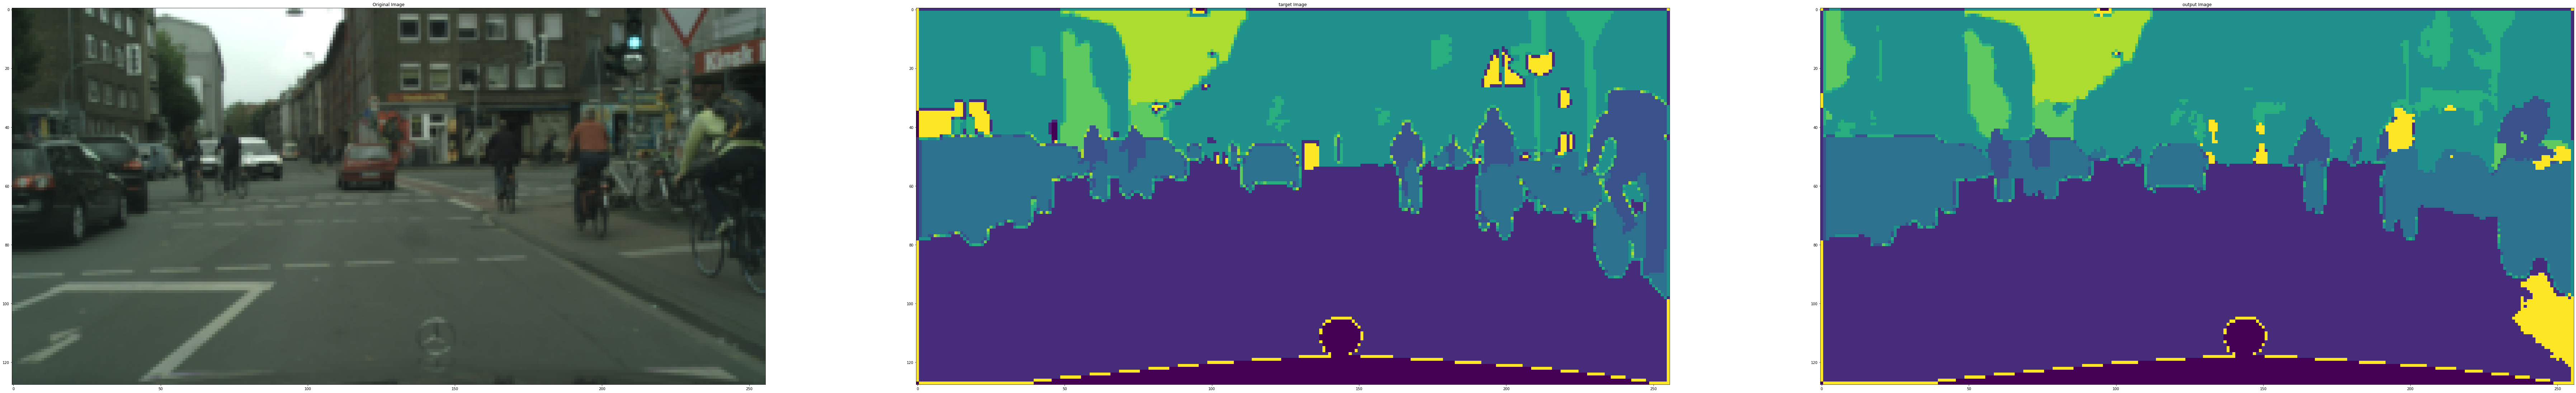

In [ ]:
model.eval()
img, target = val_load.dataset[64]

ip = img.view(1, 3, 128, 256).to(device)
out = model(ip)
output_visual(out, img, target)

# 학습 결과 시각화

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.plot(train_acc, 'b', label='train')
plt.plot(val_acc, 'r', label='val')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_loss, 'b', label='train')
plt.plot(val_loss, 'r', label='val')
plt.legend()
plt.show()

# Test

In [ ]:
def test(model, test_load):
    model.eval()
    
    val_loss = 0
    
    iou = 0
    
    with torch.no_grad():
        for data, label in val_load:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            
            loss = criterion(output, label)
            val_loss = loss.item()
            
            pred = output
            
            pred = pred.argmax(dim=1)
            
            iou += metrics(pred, label).item()
            
        val_loss /= len(val_load)
        iou /= len(val_load)
    
    return val_loss, iou

In [ ]:
t_loss, t_iou = test(model, test_load)
print(f'Loss : {t_loss},\tIOU : {t_iou}')

Loss : 0.004116959571838379,	IOU : 0.6727673749923706
